## Stroop实验

在本次的编程教程中，我们将实现一个简单的Stroop实验样本采集程序，并分析实验结果。

### 0.安装和导入必要的包

In [ ]:
%pip install opencv-python pillow numpy matplotlib seaborn pandas scipy

In [1]:
import cv2
from PIL import Image, ImageDraw, ImageFont
import numpy as np
import matplotlib.pyplot as plt
import random
import time
import seaborn
import pandas as pd
from scipy import stats

### 1. 生成图像

In [2]:
# 图像大小
H,W=600,800

In [3]:
# 设置字体
fonts={}
def font(size):
    if size not in fonts:
        fonts[size]=ImageFont.truetype('NotoSansSC-Regular.otf',size)
    return fonts[size]

In [4]:
# 绘制文本
def draw_text(text,color,size):
    # 创建空白图像
    im=Image.new('RGB',(W,H))
    d=ImageDraw.Draw(im)
    f=font(size)
    # 获取文本大小
    w,h=d.textsize(text,f)
    h*=1.2
    # 居中绘制
    d.text(((W-w)//2,(H-h)//2),text,color,f)
    return im

In [5]:
# 生成测试图片
colors=[(255,0,0),(0,255,0),(0,200,255)]
text_cn='红绿蓝'
text_en='red green blue'.split()
images=[[[draw_text(t,c,200) for t in tt] for tt in zip(text_cn,text_en)] for c in colors]
blank=Image.new('RGB',(W,H))
start=draw_text('按任意键开始',(255,255,255),100)

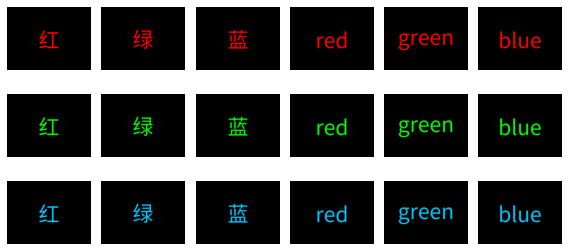

In [6]:
# 看一下效果
for i in range(18):
    plt.subplot(3,6,i+1)
    a,b=divmod(i,6)
    c,b=divmod(b,3)
    plt.imshow(images[a][b][c])
    plt.axis('off')
plt.gcf().set_size_inches([8,4])
plt.tight_layout()
plt.show()

### 2. 采集实验数据

运行下面的单元格会弹出一个窗口

**窗口有可能是最小化的，请从任务栏图标点开**

#### 实验说明

1. 请在文本出现的同时迅速回答文本的**显示颜色**，而非字面含义颜色
   
2. 回答方式为按下键盘上方那一排数字键中的`1` `2` `3`，分别对应`红` `绿` `蓝`

3. 请在测试图像出现后按一次键，不要按多余的键

4. 关闭窗口或者按 `X` 键结束样本采集

#### 2.1 熟悉实验流程

下面先简单热身一下

In [7]:
try:
    # 显示开始界面
    cv2.imshow('Test',np.array(start))
    cv2.waitKey(0)
    while True:
        for i in range(3):
            # 显示空白
            cv2.imshow('Test',np.array(blank))
            # 等待1毫秒，作用为刷新显示
            cv2.waitKey(1)
            # 等1秒
            time.sleep(1)
            # 显示测试图像
            # 因为opencv默认图像颜色通道为B、G、R，而我们的图像是R、G、B，需要转换一下
            cv2.imshow('Test',np.array(images[i][random.randint(0,2)][random.randint(0,1)])[:,:,[2,1,0]])
            # 获取按键输入，`1` `2` `3`的按键值分别为49 50 51
            key=cv2.waitKey(0)
            assert ord('x')!=key!=-1
            if key==49+i:
                # 回答正确
                cv2.imshow('Test',np.array(draw_text(f'✓',(255,255,255),100)))
                cv2.waitKey(1)
            else:
                # 回答错误
                cv2.imshow('Test',np.array(draw_text(f'×',(255,255,255),100)))
                cv2.waitKey(1)
            time.sleep(0.5)
except:
    try:
        cv2.waitKey(1)
        cv2.destroyWindow('Test')
        cv2.waitKey(1)
        cv2.destroyAllWindows()
        cv2.waitKey(1)
    except:
        pass

#### 2.2 正式测试

我们统计中/英文下正确回答的反应时间

请采集尽可能多的数据，最好大于72个样本

In [28]:
# 记录中英文回答正确所需时间
correct_time=[[],[]]
# 一共3x3x2种题型
opt=[(i,j,k) for i in range(3) for j in range(3) for k in range(2)]
# 统计样本数
cnt=0

In [29]:
try:
    cv2.imshow('Test',np.array(start))
    cv2.waitKey(0)
    while True:
        random.shuffle(opt)
        for i,j,k in opt:
            cv2.imshow('Test',np.array(blank))
            cv2.waitKey(1)
            time.sleep(1)
            t=time.time()
            cv2.imshow('Test',np.array(images[i][j][k])[:,:,[2,1,0]])
            key=cv2.waitKey(0)
            t=time.time()-t
            assert ord('x')!=key!=-1
            if key==49+i:
                correct_time[k].append(t)
                cnt+=1
                cv2.imshow('Test',np.array(draw_text(f'✓{cnt}',(255,255,255),100)))
                cv2.waitKey(1)
            else:
                cv2.imshow('Test',np.array(draw_text(f'×',(255,255,255),100)))
                cv2.waitKey(1)
            time.sleep(0.5)
except:
    try:
        cv2.waitKey(1)
        cv2.destroyWindow('Test')
        cv2.waitKey(1)
        cv2.destroyAllWindows()
        cv2.waitKey(1)
    except:
        pass
print(f'数据采集结束，共{cnt}个样本，其中中文{len(correct_time[0])}个，英文{len(correct_time[1])}个')
if len(correct_time[0])==0 or len(correct_time[1])==0:
    print('数据不足，请再多采集一点')

数据采集结束，共72个样本


### 3. 结果分析

先简单介绍一下箱型图，它由美国的统计学家John Tukey于1977年发明，图中标出了三个四分位数：Q1、中位数(median)、Q3，即有25%的样本小于Q1，50%的样本小于中位数，75%的样本小于Q3。记IQR=Q3-Q1，我们在Q1-1.5IQR和Q3+1.5IQR的位置画两条竖线，表示样本理应大部分集中在这区域内，超出范围的称为离群值(outlier)。图示如下：

<img src="./box_plot.png" width="600px"/>

seaborn包提供了直接绘制箱型图的`boxplot`函数，我们用它绘制箱型图。

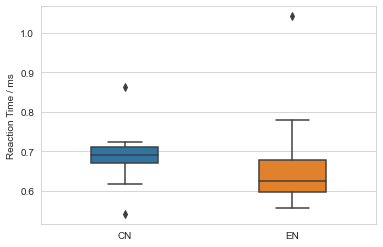

In [30]:
# 为了便于画图，将样本数补充为一样多
c1,c2=correct_time
l=max(len(c1),len(c2))
c1=c1+[np.nan]*(l-len(c1))
c2=c2+[np.nan]*(l-len(c2))

df=pd.DataFrame({'CN':c1,'EN':c2})
seaborn.set_style("whitegrid")
seaborn.boxplot(data=df,orient='v',width=0.4)
plt.ylabel("Reaction Time / ms")
plt.show()

In [1]:
if np.median(correct_time[0])>np.median(correct_time[1]):
    print('比较二者的反应时间中位数，我们可以发现文本为英文时反应速度更快。')
else:
    print('比较二者的反应时间中位数，我们可以发现文本为中文时反应速度更快。')

比较二者的反应时间中位数，我们可以发现文本为英文时反应速度更快。


在数学上，我们可以使用[Mann-Whitney U测试](https://www.reneshbedre.com/blog/mann-whitney-u-test.html)判断“文本为中文时反应时间更长”这一结论的错误概率，写出假设如下：

$H_0: p(x_i>y_i)=0.5$，即文本为中文和英文时反应时间中位数相近

$H_1: p(x_i>y_i)>0.5$，即文本为中文时反应时间中位数比英文更长

In [5]:
p=stats.mannwhitneyu(x=correct_time[0],y=correct_time[1],alternative='greater').pvalue
print(f'计算出p值为{p:.4f}，因此我们接受H1假设的错误概率为{p*100:.2f}%')

计算出p值为0.1657，因此我们接受H1假设的错误概率为16.57%
